# 数据的载入

- For images, packages such as Pillow, OpenCV are useful
- For audio, packages such as scipy and librosa
- For text, either raw Python or Cython based loading, or NLTK and SpaCy are useful

下面先看看 `torchvision` 是如何载入数据集的？(参考：https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [1]:
import torch
from torchvision import transforms
from torchvision.datasets import CIFAR10

`torchvision` datasets 的输出是取值为 `[0, 1]` PILImage 对象. 我们需要转换 Tensors 到 `[-1, 1]`。

- `transforms.ToTensor()`：把一个取值范围是`[0,255]` 的 PIL.Image 或者 `shape` 为 `(H,W,C)` 的 `numpy.ndarray`，转换成形状为 `[C,H,W]`，取值范围是 `[0,1.0]` 的 `torch.FloadTensor`。
- `transforms.Normalize`：给定均值：`(R,G,B)` 方差：`(R,G,B)`，将会把 Tensor 正则化。

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = CIFAR10(
    root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4, shuffle=True, num_workers=2)

testset = CIFAR10(
    root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
           'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


下面展示一些图片：

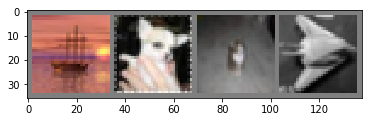

 ship   dog   cat plane


In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

from torchvision.utils import make_grid
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# 定义一个 Convolutional Neural Network

In [4]:
from torch import nn
from torch.nn import functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

# 定义损失函数和优化器

In [5]:
from torch import optim

criterion = nn.CrossEntropyLoss()  # 损失函数
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)  # 优化器

# 训练网络

In [6]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1,
                                            running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.175
[1,  4000] loss: 1.790
[1,  6000] loss: 1.662
[1,  8000] loss: 1.577
[1, 10000] loss: 1.515
[1, 12000] loss: 1.487
[2,  2000] loss: 1.393
[2,  4000] loss: 1.362
[2,  6000] loss: 1.344
[2,  8000] loss: 1.304
[2, 10000] loss: 1.298
[2, 12000] loss: 1.259
Finished Training


# 测试模型

测试个批量的数据：

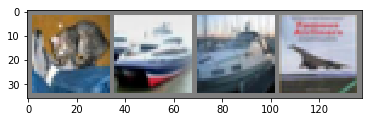

GroundTruth:    cat  ship  ship plane


In [7]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


In [9]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


In [10]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 50 %
Accuracy of   car : 64 %
Accuracy of  bird : 49 %
Accuracy of   cat : 30 %
Accuracy of  deer : 35 %
Accuracy of   dog : 53 %
Accuracy of  frog : 64 %
Accuracy of horse : 67 %
Accuracy of  ship : 82 %
Accuracy of truck : 65 %


# 在 GPU 上训练

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [12]:
net.to(device)

inputs, labels = inputs.to(device), labels.to(device)

RuntimeError: cuda runtime error (30) : unknown error at ..\aten\src\THC\THCGeneral.cpp:87